# Abalore Rings Prediction Model

In [162]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from IPython.display import clear_output, display
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Dataset Analysis

In [163]:
# Load a dataset into a Pandas Dataframe
dataset_df = pd.read_csv('./input/playground-series-s4e4/train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))
# Display the first 5 examples
dataset_df.head(5)

Full train dataset shape is (90615, 10)


,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [164]:
print(len(dataset_df['Rings'].unique()))
dataset_df['Rings'].unique()

28


array([11,  6, 10,  9,  4,  8, 15,  7, 12, 20, 17, 13, 14,  5, 23,  3, 22,
       16, 18, 19, 21, 25,  1, 29,  2, 27, 24, 26])

### NAN checks

Thankfully no null values.

In [165]:
dataset_df.isnull().sum().sort_values(ascending=False)

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64

In [166]:
dataset_df.describe(include='all')

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
unique,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,33093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,45307.000000,NaN,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,26158.441658,NaN,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.000000,NaN,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,22653.500000,NaN,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,45307.000000,NaN,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,67960.500000,NaN,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000


In [167]:
print("Sex:")
print(dataset_df.Sex.describe())
print(dataset_df.Sex.unique())

Sex:
count     90615
unique        3
top           I
freq      33093
Name: Sex, dtype: object
['F' 'I' 'M']


### Gender Analysis

There seems to be some correlation between the size of the Abalone's and its gender. This makes sense since infants are usually smaller than the adults.

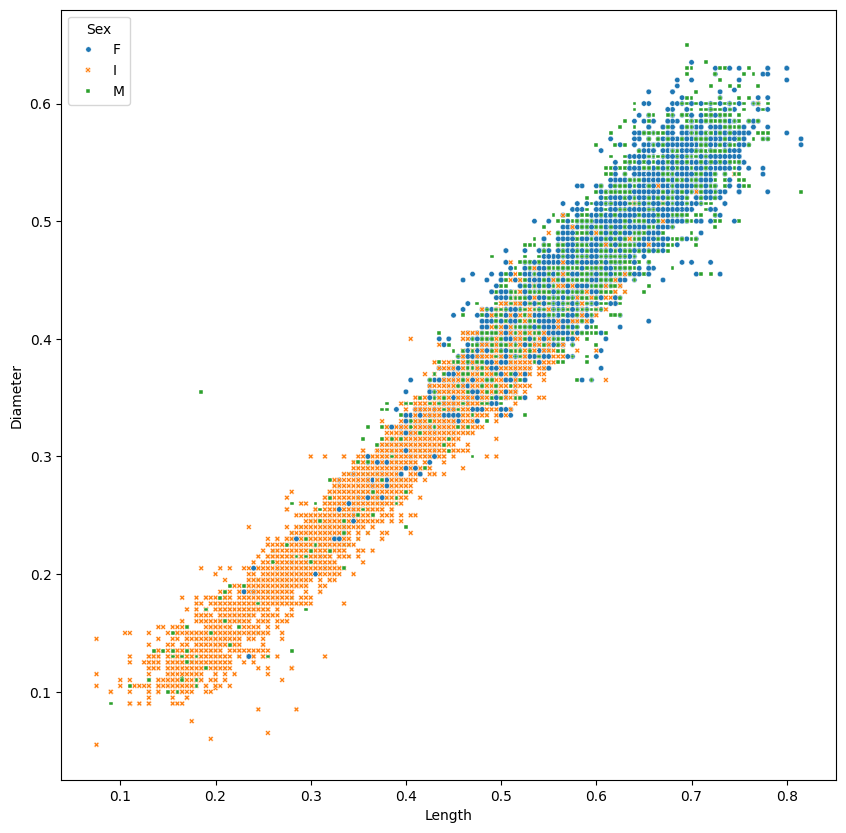

In [168]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

sns.scatterplot(data=dataset_df, x='Length', y='Diameter', hue='Sex', ax=ax, s=15, style="Sex")
plt.show()

Infants tend to have smaller rings, whereas the distribution of number of rings for males and females seem to be similar. This suggests that the number of rings is mostly determined by size than anything else. We could potentially just distinguish infants from adults.

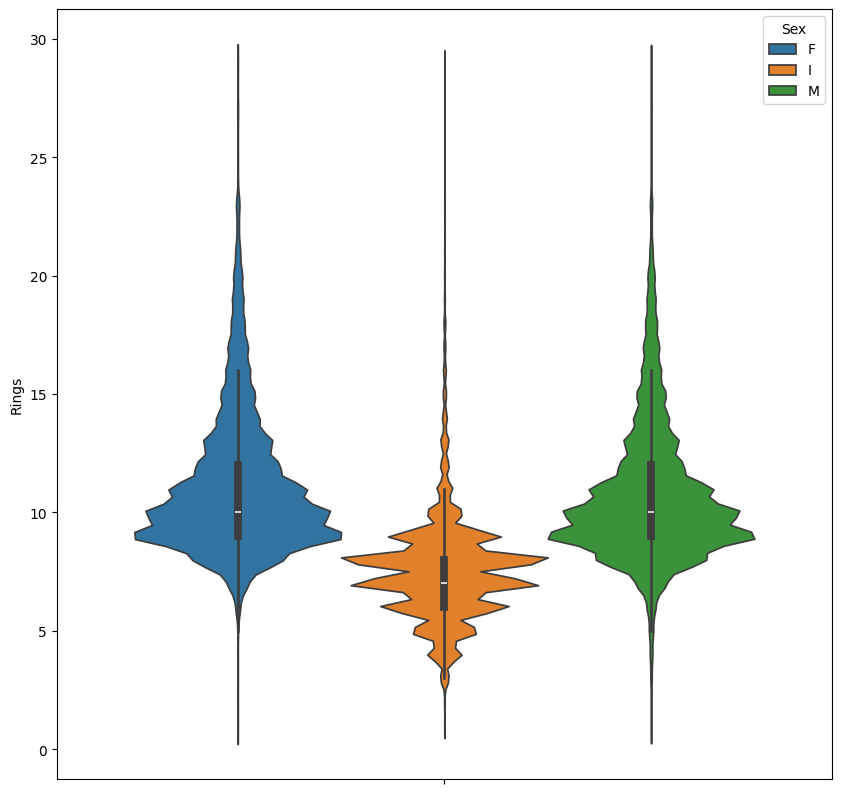

In [169]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

sns.violinplot(data=dataset_df, hue='Sex', y='Rings', ax=ax)
plt.show()

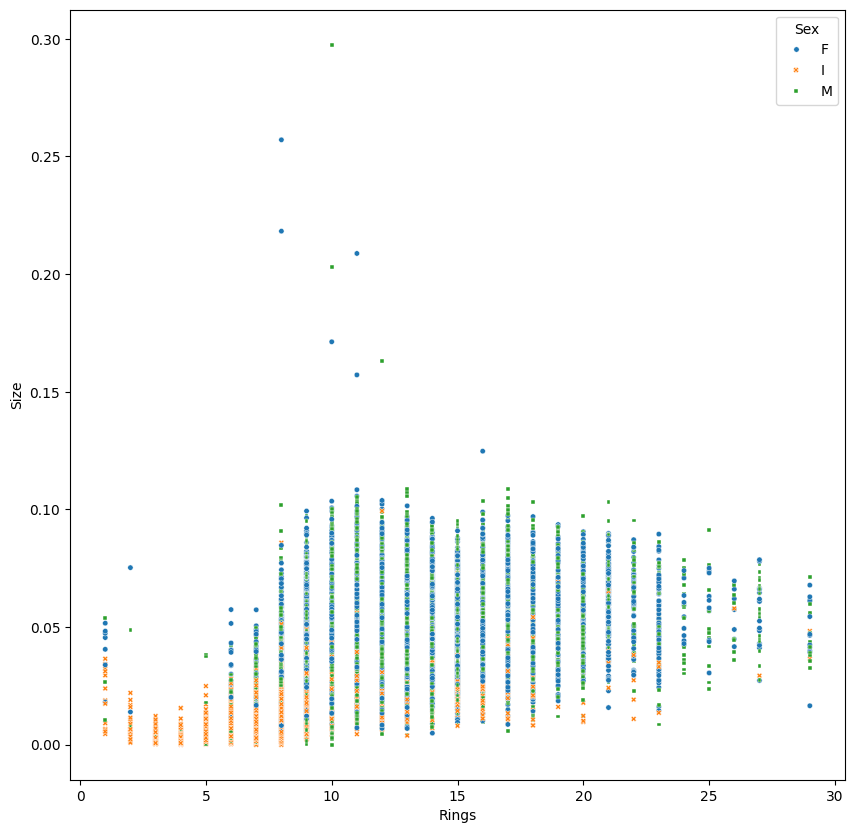

In [170]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

size_df = dataset_df
size_df['Size'] = dataset_df['Length'] * dataset_df['Diameter'] * dataset_df['Height']
sns.scatterplot(data=size_df, x='Rings', y='Size', hue='Sex', ax=ax, s=15, style="Sex")
plt.show()
size_df.drop(columns=['Size'], inplace=True)

### Weight Analysis

Apparently `Whole weight.1` and `Whole weight.2` mean `Shucked Weight` and `Viscera Weight`, according to https://www.kaggle.com/competitions/playground-series-s4e4/discussion/488073. For my own convenience, I'm renaming these columns. It seems that the sum of the weights `shucked` and `shell`, or the total weight of the Abalone post shucking, should be strictly less than the `weight_whole`.

In [171]:
dataset_df['weight_whole'] = dataset_df['Whole weight']
dataset_df['weight_shucked'] = dataset_df['Whole weight.1']
dataset_df['weight_viscera'] = dataset_df['Whole weight.2']
dataset_df['weight_shell'] = dataset_df['Shell weight']
dataset_df.drop(columns=['Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight'], inplace=True)

There are roughly 296 entries where the sum of the post-shucking weights are greater than the whole weight, which is unlikely. One abalone almost a third of its own weight.

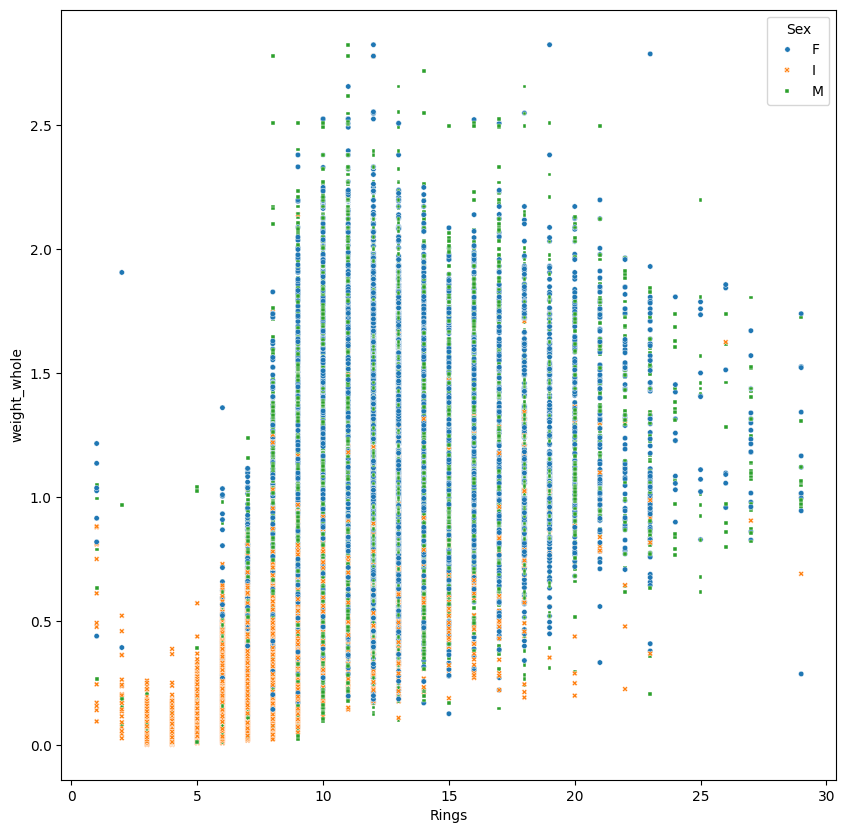

In [172]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

sns.scatterplot(data=dataset_df, x='Rings', y='weight_whole', hue='Sex', ax=ax, s=15, style="Sex")
plt.show()

In [173]:
w_cols = ['weight_shucked', 'weight_shell']
dataset_df['weight_sum'] = dataset_df[w_cols].sum(axis=1)
print((dataset_df['weight_sum'] <= dataset_df['weight_whole']).value_counts())
print()
print(f"mean: {((dataset_df['weight_whole'] - dataset_df['weight_sum']) > 0).mean()}")
print(f"std: {((dataset_df['weight_whole'] - dataset_df['weight_sum']) > 0).std()}")
print()
weight_outliers = dataset_df.loc[(dataset_df['weight_sum'] > dataset_df['weight_whole'])]
print(weight_outliers.id.count())
print(f"mean: {(weight_outliers['weight_sum'] - weight_outliers['weight_whole']).mean()}")
print(f"std: {(weight_outliers['weight_sum'] - weight_outliers['weight_whole']).std()}")
print(f"max: {(weight_outliers['weight_sum'] - weight_outliers['weight_whole']).max()}")
print(f"min: {(weight_outliers['weight_sum'] - weight_outliers['weight_whole']).min()}")
print()
# abalone that gained 0.4595g after being shucked had a whole weight of 1.218g
odd_id = (weight_outliers['weight_sum'] - weight_outliers['weight_whole']).argmax()
dataset_df['weight_whole'][odd_id]

True     90319
False      296
dtype: int64

mean: 0.9965347900457981
std: 0.058764278121165886

296
mean: 0.04483614864864865
std: 0.10479788947301452
max: 0.4595
min: 3.469446951953614e-18



1.218

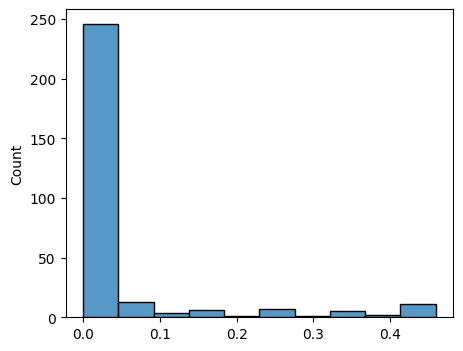

In [174]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))

sns.histplot(data=(weight_outliers['weight_sum'] - weight_outliers['weight_whole']), bins=10, ax=ax)
plt.show()

For now, we'll simply drop the outliers. Maybe later we could include the outliers whose difference between `weight_shucked + weight_shell` and `weight_whole` is negligible.

In [175]:
dataset_df.drop(dataset_df.loc[dataset_df['weight_sum'] > dataset_df['weight_whole']].index, inplace=True)

We can see that no abalones have `weight_shucked`, `weight_shell`, or `weight_viscera` greater than `weight_whole`.

In [176]:
print((dataset_df['weight_shucked'] < dataset_df['weight_whole']).value_counts())
print((dataset_df['weight_shell'] < dataset_df['weight_whole']).value_counts())
print((dataset_df['weight_viscera'] < dataset_df['weight_whole']).value_counts())

True    90319
dtype: int64
True    90319
dtype: int64
True    90319
dtype: int64


### Heigh, Diameter, Length

We'll also drop the few abalones with height 0.

In [177]:
dataset_df.loc[(dataset_df['Height'] == 0)].count()

id                4
Sex               4
Length            4
Diameter          4
Height            4
Rings             4
weight_whole      4
weight_shucked    4
weight_viscera    4
weight_shell      4
weight_sum        4
dtype: int64

In [178]:
dataset_df.drop(dataset_df.loc[(dataset_df['Height'] == 0)].index, inplace=True)

### Feature Correlation

We can observe high correlation between all numerical features, which is expected. Don't think there's much point to applying pca here though, considering we have only 7 input features to work with.

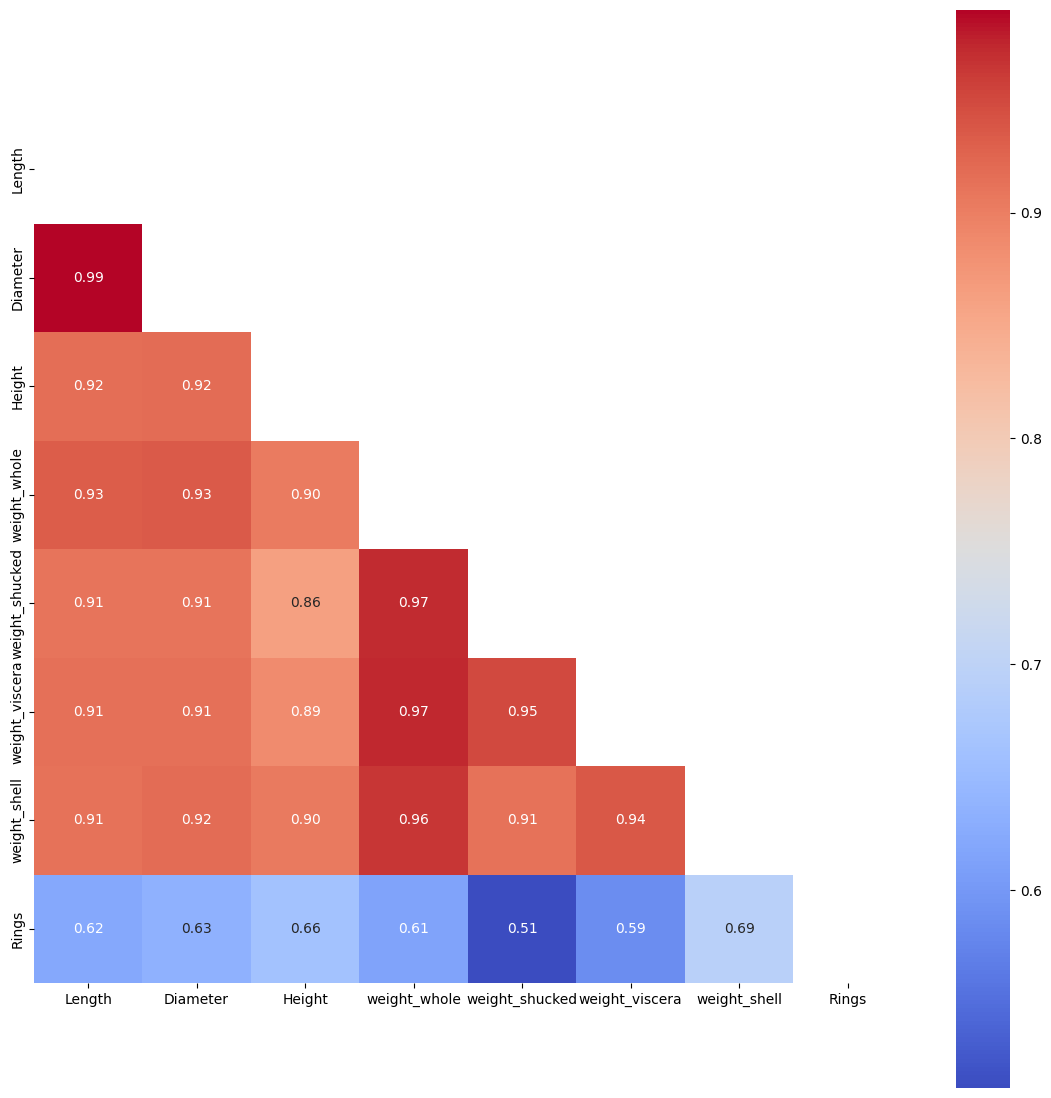

In [179]:
# reorganizing columns
dataset_df = dataset_df[[col for col in dataset_df.columns if col != 'Rings'] + ['Rings']]

corr = dataset_df.drop(columns=['Sex', 'id', 'weight_sum']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(14, 14))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", square=True, cmap='coolwarm')
plt.show()

### Training

In [180]:
X = dataset_df.drop(columns=['weight_sum', 'Rings', 'Sex', 'id'])
y = dataset_df['Rings']
# X['sex_M'] = (dataset_df['Sex'] == 'M').astype(float)
# X['sex_F'] = (dataset_df['Sex'] == 'F').astype(float)
# X['sex_I'] = (dataset_df['Sex'] == 'I').astype(float)
def sex_to_int(x):
  if x == 'M':
    return 0
  elif x == 'F':
    return 1
  else:
    return 2
X['sex'] = dataset_df['Sex'].apply(sex_to_int)
X.head()

,Length,Diameter,Height,weight_whole,weight_shucked,weight_viscera,weight_shell,sex
0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,1
1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,1
2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,2
3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,0
4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,2


In [181]:
X_train, X_test, y_train, y_test = \
  train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)

In [182]:
class AbaloneDataset(data.Dataset):
  def __init__(self, X_df, y_df):
    self.X = torch.Tensor(X_df.values)
    self.y = torch.Tensor(y_df.values)
    self.l = self.X.shape[0]
  
  def __getitem__(self, index):
    return self.X[index], self.y[index]
  
  def __len__(self):
    return self.l

In [183]:
# the evaluation metric, root mean squared logarithmic error
class RMSLELoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.mse = nn.MSELoss()
    
  def forward(self, pred, actual):
    return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [184]:
train_dataset = AbaloneDataset(X_train, y_train)
test_dataset = AbaloneDataset(X_test, y_test)

## Deep Learning Regression Model

Define Model and Trainer class.

Performance-wise no difference between the MLP only model and the gender embedding model. Maybe I need to implement a different loss function? Train the embedding first and then train the MLP.

In [185]:
# simple linear regression model with an embedding layer for genders
class AbaloreRingLR(nn.Module):
  def __init__(self, dim_hiddens=[32], dim_input=10, dropout=0.2):
    super(AbaloreRingLR, self).__init__()
    # self.num_sex = num_sex
    # # embeddings for the gender
    # self.sex_embed = nn.Embedding(num_sex, dim_sex_embed) 
    self.l1 = nn.Sequential(
      nn.Linear(dim_input, dim_hiddens[0]),
      nn.LeakyReLU(),
    )
    self.lh = nn.ModuleList([
      nn.Sequential(
        nn.Linear(dim_hiddens[i], dim_hiddens[i+1]),
        # nn.Dropout(p=dropout),
        nn.LeakyReLU(),
        nn.BatchNorm1d(dim_hiddens[i+1]),
      ) for i in range(len(dim_hiddens)-1)
    ])
    self.lo = nn.Linear(dim_hiddens[-1], 1)
  
  def forward(self, inputs):
    X = inputs
    h = self.l1(X)
    for hidden in self.lh:
      h = hidden(h)
    h = self.lo(h)
    return 30 * F.sigmoid(h) # ensure output is positive

In [186]:
# simple linear regression model with a sigmoid activation at the final layer for an output range
class AbaloreRingLRSexEmbed(nn.Module):
  def __init__(self, dim_hiddens=[32], numerical_features=7, num_sex=3, dim_sex_embed=1, dropout=0.2):
    super(AbaloreRingLRSexEmbed, self).__init__()
    self.dim_sex_embed = int(dim_sex_embed)
    self.numerical_features = numerical_features
    # embeddings for the gender
    self.sex_embed = nn.Embedding(num_sex, dim_sex_embed)
    self.bn1 = nn.BatchNorm1d(numerical_features)
    self.l1 = nn.Sequential(
      nn.Linear(numerical_features+dim_sex_embed, dim_hiddens[0]),
      # nn.Dropout(p=dropout),
      nn.LeakyReLU(),
      nn.BatchNorm1d(dim_hiddens[0]),
    )
    self.lh = nn.ModuleList([
      nn.Sequential(
        nn.Linear(dim_hiddens[i], dim_hiddens[i+1]),
        # nn.Dropout(p=dropout),
        nn.LeakyReLU(),
        nn.BatchNorm1d(dim_hiddens[i+1]),
      ) for i in range(len(dim_hiddens)-1)
    ])
    self.lo = nn.Linear(dim_hiddens[-1], 1)
  
  def forward(self, inputs):
    numerical_input, gender = torch.split(inputs, [self.numerical_features,1], dim=1)
    embedded_sex = self.sex_embed(gender.long()).reshape(inputs.shape[0], self.dim_sex_embed)
    normalized_numerical_input = self.bn1(numerical_input)
    X = torch.cat((normalized_numerical_input, embedded_sex), dim=1)
    h = self.l1(X)
    for hidden in self.lh:
      h = hidden(h)
    h = self.lo(h)
    return 30 * F.sigmoid(h)

In [187]:
class Trainer:
    def __init__(self, model):
        self.model = model
    
    def get_model(self):
      return self.model
    
    def train(self, train_dataset, val_dataset, batch_size=128, lr=1e4, lambda_=5e3, epochs=50):
        train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = data.DataLoader(dataset=val_dataset, batch_size=batch_size)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, amsgrad=False)

        train_losses = []
        val_losses = []
        train_perf = []
        val_perf = []
        
        loss_fn=nn.MSELoss()
        
        for epoch in range(epochs):
            # clear_output(wait=True)
            print(f"epoch {epoch+1} / {epochs}")

            total_loss = 0.
            train_rmsle = 0.
            perplexity = 0.
            total_loss = 0.

            for i, (X, y) in enumerate(train_loader):
                self.model.train()

                # X_inputs, X_genders = torch.split(X, [7,1], dim=1)
                # y_hat = self.model(X_inputs, X_genders.squeeze().long()).squeeze()
                y_hat = self.model(X).squeeze()

                loss = loss_fn(y_hat, y)
                
                if lambda_ > 0:
                    l2_reg = 0
                    for parameter in self.model.parameters():
                        l2_reg = l2_reg + torch.sum(torch.pow(parameter, 2)) * .5
                    loss = loss + l2_reg * lambda_
        
                total_loss = total_loss + loss.item()

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                # rmsle of the training set
                with torch.no_grad():
                    train_rmsle = train_rmsle + torch.sum(torch.pow(torch.log(y_hat + 1) - \
                                                                     torch.log(y + 1), 2))

                # cross val
                if i % 100 == 99:
                    self.model.eval()
                    with torch.no_grad():
                        val_rmsle = 0.
                        val_loss = 0.
                        for j, (val_X, val_y) in enumerate(val_loader):
                            # val_X_inputs, val_X_genders = torch.split(val_X, [7,1], dim=1)
                            # val_y_hat = self.model(val_X_inputs, val_X_genders.squeeze().long()).squeeze()
                            val_y_hat = self.model(val_X).squeeze()
                            val_rmsle = val_rmsle + torch.sum(torch.pow(torch.log(val_y_hat + 1) - \
                                                                torch.log(val_y + 1), 2))
                            val_loss = val_loss + loss_fn(val_y_hat, val_y)
                        val_rmsle = torch.sqrt(val_rmsle / len(val_dataset))
                        print(f"val_rmsle: {val_rmsle}")
                        val_perf.append(val_rmsle)
                        val_loss = val_loss
                        val_losses.append(val_loss / len(val_loader))
                        
            train_rmsle = torch.sqrt(train_rmsle / len(train_dataset))
            train_perf.append(train_rmsle)
            train_losses.append(total_loss / len(train_loader))
        
        return train_losses, val_losses, train_perf, val_perf

In [188]:
# trainer_1 = Trainer(AbaloreRingLR(dim_hiddens=[32,16], dim_input=10, dropout=0.2))
# train_losses, val_losses, train_metrics, val_metrics = trainer_1.train( \
# 	train_dataset=train_dataset, val_dataset=test_dataset, \
# 	batch_size=256, lr=.0001, lambda_=.001, epochs=100)
trainer_1 = Trainer(AbaloreRingLRSexEmbed(dim_hiddens=[16, 8], numerical_features=7, num_sex=3, dim_sex_embed=1, dropout=0.2))
train_losses, val_losses, train_metrics, val_metrics = trainer_1.train( \
  train_dataset=train_dataset, val_dataset=test_dataset, \
  batch_size=256, lr=.00001, lambda_=0, epochs=30)

epoch 1 / 30
val_rmsle: 0.6374952793121338
val_rmsle: 0.6284869909286499
epoch 2 / 30
val_rmsle: 0.6101710200309753
val_rmsle: 0.6029825806617737
epoch 3 / 30
val_rmsle: 0.5907557010650635
val_rmsle: 0.5870294570922852
epoch 4 / 30
val_rmsle: 0.5759673714637756
val_rmsle: 0.576919436454773
epoch 5 / 30
val_rmsle: 0.5632363557815552
val_rmsle: 0.5633673071861267
epoch 6 / 30
val_rmsle: 0.5496844053268433
val_rmsle: 0.5465819239616394
epoch 7 / 30
val_rmsle: 0.5408914685249329
val_rmsle: 0.5332908034324646
epoch 8 / 30
val_rmsle: 0.5307878851890564
val_rmsle: 0.5225265026092529
epoch 9 / 30
val_rmsle: 0.5211441516876221
val_rmsle: 0.519443929195404
epoch 10 / 30
val_rmsle: 0.5141573548316956
val_rmsle: 0.5128641724586487
epoch 11 / 30
val_rmsle: 0.5082534551620483
val_rmsle: 0.5037248730659485
epoch 12 / 30
val_rmsle: 0.5012415051460266
val_rmsle: 0.49745020270347595
epoch 13 / 30
val_rmsle: 0.49283653497695923
val_rmsle: 0.4909105598926544
epoch 14 / 30
val_rmsle: 0.4879079759120941
val

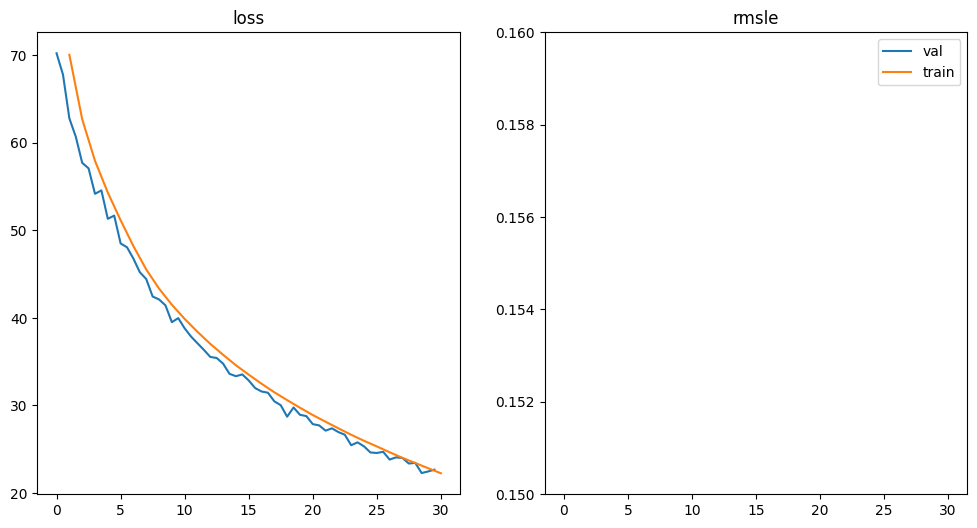

tensor(0.4076)


In [189]:
eval_per_epoch = len(val_metrics) / len(train_metrics)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12,6)

ax[0].plot([i / eval_per_epoch for i in range(len(val_losses))], val_losses, label='val')
ax[0].plot([i + 1 for i in range(len(train_losses))], train_losses, label='train')
ax[0].set_title('loss')

ax[1].plot([i / eval_per_epoch for i in range(len(val_metrics))], val_metrics, label='val')
ax[1].plot([i + 1 for i in range(len(train_metrics))], train_metrics, label='train')
ax[1].set_ylim(0.15, 0.16)
ax[1].set_title('rmsle')

plt.legend()
plt.show()

print(val_metrics[-1])

## Classification Model

Instead of predicitng the number of Rings, we assign a given Abalone to one of the observed 28 Ring classifications. First we have to adjust the targets so that they are within the range of 0 to 27.

In [190]:
class AbaloneDatasetRingClass(data.Dataset):
    def __init__(self, X_df, y_df):
        self.X = torch.Tensor(X_df.values)
        self.y = torch.zeros(len(y_df.values), 28)
        
        for i in range(len(y_df.values)):
            y = y_df.values[i]
            if y < 28:
                y = y - 1
            else:
                y = y - 2
            self.y[i][y] = 1.    

        self.l = self.X.shape[0]
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.l

train_dataset_2 = AbaloneDatasetRingClass(X_train, y_train)
test_dataset_2 = AbaloneDatasetRingClass(X_test, y_test)

In [191]:
# simple linear regression model with a sigmoid activation at the final layer for an output range
class AbaloreRingClassifier(nn.Module):
    def __init__(self, dim_hiddens=[32], numerical_features=7, num_sex=3, dim_output=28, dim_sex_embed=1, dropout=0.2):
        super(AbaloreRingClassifier, self).__init__()
        self.dim_sex_embed = int(dim_sex_embed)
        self.numerical_features = numerical_features
        # embeddings for the gender
        self.sex_embed = nn.Embedding(num_sex, dim_sex_embed)
        self.bn1 = nn.BatchNorm1d(numerical_features)
        self.l1 = nn.Sequential(
            nn.Linear(numerical_features+dim_sex_embed, dim_hiddens[0]),
            nn.Dropout(p=dropout),
            nn.LeakyReLU(),
            nn.BatchNorm1d(dim_hiddens[0]),
        )
        self.lh = nn.ModuleList([
            nn.Sequential(
            nn.Linear(dim_hiddens[i], dim_hiddens[i+1]),
            nn.Dropout(p=dropout),
            nn.LeakyReLU(),
            nn.BatchNorm1d(dim_hiddens[i+1]),
            ) for i in range(len(dim_hiddens)-1)
        ])
        self.lo = nn.Linear(dim_hiddens[-1], dim_output)

    def forward(self, inputs):
        numerical_input, gender = torch.split(inputs, [self.numerical_features,1], dim=1)
        embedded_sex = self.sex_embed(gender.long()).reshape(inputs.shape[0], self.dim_sex_embed)
        normalized_numerical_input = self.bn1(numerical_input)
        X = torch.cat((normalized_numerical_input, embedded_sex), dim=1)
        h = self.l1(X)
        for hidden in self.lh:
            h = hidden(h)
        h = self.lo(h)
        return h

In [192]:
class Trainer2:
    def __init__(self, model):
        self.model = model
    
    def get_model(self):
      return self.model
    
    def train(self, train_dataset, val_dataset, batch_size=128, lr=1e4, lambda_=5e3, epochs=50):
        train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = data.DataLoader(dataset=val_dataset, batch_size=batch_size)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, amsgrad=False)

        train_losses = []
        val_losses = []
        # train_perf = []
        # val_perf = []
        
        for epoch in range(epochs):
            # clear_output(wait=True)
            print(f"epoch {epoch+1} / {epochs}")

            total_loss = 0.
            train_rmsle = 0.
            perplexity = 0.
            total_loss = 0.
            
            loss_fn = nn.CrossEntropyLoss()

            for i, (X, y) in enumerate(train_loader):
                self.model.train()

                y_hat = self.model(X).squeeze()
                loss = loss_fn(y_hat, y)
                l2_reg = 0
                if lambda_ > 0:
                    for parameter in self.model.parameters():
                        l2_reg = l2_reg + torch.sum(torch.pow(parameter, 2)) * .5
                loss = loss + l2_reg * lambda_
                total_loss = total_loss + loss.item()

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                # # rmsle of the training set
                # with torch.no_grad():
                #     train_rmsle = train_rmsle + torch.sum(torch.pow(torch.log((torch.argmax(y_hat, dim=1)) + 1) - \
                #                                                      torch.log((y) + 1), 2))

                # cross val
                if i % 100 == 99:
                    self.model.eval()
                    with torch.no_grad():
                        val_rmsle = 0.
                        val_loss = 0.
                        for j, (val_X, val_y) in enumerate(val_loader):
                            val_y_hat = self.model(val_X).squeeze()
                            # val_rmsle = val_rmsle + torch.sum(torch.pow(torch.log((torch.argmax(val_y_hat, dim=1)) + 1) - \
                            #                                     torch.log((val_y) + 1), 2))
                            val_loss = val_loss + loss_fn(val_y_hat, val_y)
                        # val_rmsle = torch.sqrt(val_rmsle / len(val_dataset))
                        # print(f"val_rmsle: {val_rmsle}")
                        # val_perf.append(val_rmsle)
                        val_loss = val_loss
                        val_losses.append(val_loss / len(val_loader))
                        
            # train_rmsle = torch.sqrt(train_rmsle / len(train_dataset))
            # train_perf.append(train_rmsle)
            train_losses.append(total_loss / len(train_loader))
        
        return train_losses, val_losses

In [193]:
trainer_2 = Trainer2(AbaloreRingClassifier(dim_hiddens=[128], numerical_features=7, num_sex=3, dim_sex_embed=32, dropout=0))
train_losses_2, val_losses_2 = trainer_2.train( \
  train_dataset=train_dataset_2, val_dataset=test_dataset_2, \
  batch_size=256, lr=.0001, lambda_=0.01, epochs=30)

epoch 1 / 30
epoch 2 / 30
epoch 3 / 30
epoch 4 / 30
epoch 5 / 30
epoch 6 / 30
epoch 7 / 30
epoch 8 / 30
epoch 9 / 30
epoch 10 / 30
epoch 11 / 30
epoch 12 / 30
epoch 13 / 30
epoch 14 / 30
epoch 15 / 30
epoch 16 / 30
epoch 17 / 30
epoch 18 / 30
epoch 19 / 30
epoch 20 / 30
epoch 21 / 30
epoch 22 / 30
epoch 23 / 30
epoch 24 / 30
epoch 25 / 30
epoch 26 / 30
epoch 27 / 30
epoch 28 / 30
epoch 29 / 30
epoch 30 / 30


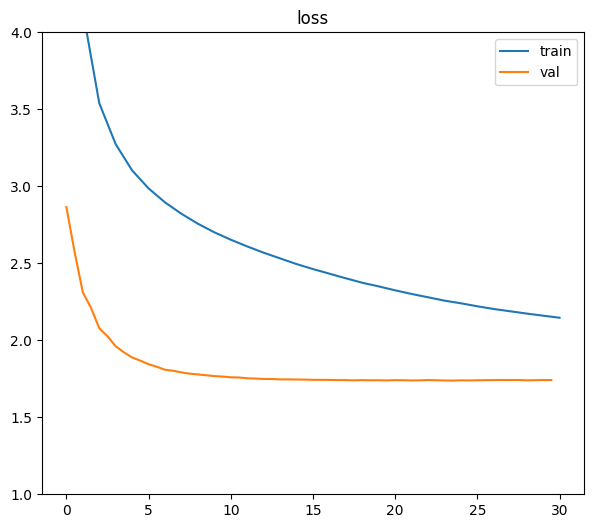

In [194]:
eval_per_epoch = len(val_losses_2) / len(train_losses_2)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7,6)

ax.plot([i + 1 for i in range(len(train_losses_2))], train_losses_2, label='train')
ax.plot([i / eval_per_epoch for i in range(len(val_losses_2))], val_losses_2, label='val')
ax.set_ylim(1., 4.)
ax.set_title('loss')

plt.legend()
plt.show()

In [195]:
model = trainer_2.get_model()
model.eval()
with torch.no_grad():
    val_rmsle = 0.
    val_loss = 0.
    y = test_dataset_2.y
    y_hat = model(test_dataset_2.X)
    #
    y_adjusted = torch.zeros(y.shape)
    y_hat_adjusted = torch.zeros(y_hat.shape)
    for i, (y_i, y_hat_i) in enumerate(zip(y, y_hat)):
        y_i_id = torch.argmax(y_i)
        y_hat_i_id = torch.argmax(F.softmax(y_hat_i, dim=0))
        #
        if y_i_id < 27:
            y_i_id = y_i_id + 1
        else:
            y_i_id = y_i_id + 2
        if y_hat_i_id < 27:
            y_hat_i_id = y_hat_i_id + 1
        else:
            y_hat_i_id = y_hat_i_id + 2
        # print(f"{y_hat_i_id} vs {y_i_id}")
        y_adjusted[i] = y_i_id
        y_hat_adjusted[i] = y_hat_i_id
    #
    rmsle = torch.log(y_hat_adjusted + 1) - torch.log(y_adjusted + 1)
    rmsle = torch.pow(rmsle, 2)
    rmsle = torch.mean(rmsle)
    rmsle = torch.sqrt(rmsle)
    print(rmsle)

tensor(0.1736)


## XGBoost Classifier

In [196]:
def adjust_target(y):
    if y < 28:
        return y - 1
    else:
        return y - 2

In [199]:
xgb_model = XGBClassifier(n_estimators = 854, learning_rate = 0.03, verbosity = 1, random_state = 42, enable_categorical=True, objective='reg:squarederror')
# **{'n_estimators': 854, 'max_depth': 11, 'learning_rate': 0.030717596662544165, 'subsample': 0.5737027140612267, 'colsample_bytree': 0.4645458138934496, 'min_child_weight': 4, 'gamma': 0.06533190534356587}, objective= 'reg:squarederror',eval_metric= 'rmse',random_state= 42
xgb_model.fit(X_train, y_train.apply(adjust_target), eval_set = [(X_test, y_test.apply(adjust_target))], early_stopping_rounds = 10)

[0]	validation_0-mlogloss:3.24188


/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:3.16403
[2]	validation_0-mlogloss:3.09523
[3]	validation_0-mlogloss:3.03359
[4]	validation_0-mlogloss:2.97767
[5]	validation_0-mlogloss:2.92660
[6]	validation_0-mlogloss:2.87953
[7]	validation_0-mlogloss:2.83571
[8]	validation_0-mlogloss:2.79493
[9]	validation_0-mlogloss:2.75673
[10]	validation_0-mlogloss:2.72091
[11]	validation_0-mlogloss:2.68713
[12]	validation_0-mlogloss:2.65522
[13]	validation_0-mlogloss:2.62510
[14]	validation_0-mlogloss:2.59648
[15]	validation_0-mlogloss:2.56924
[16]	validation_0-mlogloss:2.54341
[17]	validation_0-mlogloss:2.51873
[18]	validation_0-mlogloss:2.49523
[19]	validation_0-mlogloss:2.47267
[20]	validation_0-mlogloss:2.45099
[21]	validation_0-mlogloss:2.43037
[22]	validation_0-mlogloss:2.41056
[23]	validation_0-mlogloss:2.39148
[24]	validation_0-mlogloss:2.37311
[25]	validation_0-mlogloss:2.35543
[26]	validation_0-mlogloss:2.33849
[27]	validation_0-mlogloss:2.32211
[28]	validation_0-mlogloss:2.30637
[29]	validation_0-mlogloss:2.

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=854, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

## Sex -> Maturity

In [63]:
X = dataset_df.drop(columns=['weight_sum', 'Rings', 'Sex', 'id'])
y = dataset_df['Rings']
# X['sex_M'] = (dataset_df['Sex'] == 'M').astype(float)
# X['sex_F'] = (dataset_df['Sex'] == 'F').astype(float)
# X['sex_I'] = (dataset_df['Sex'] == 'I').astype(float)
def sex_to_int(x):
  if x == 'I':
    return 0
  else:
    return 1
X['maturity'] = dataset_df['Sex'].apply(sex_to_int)
X.head()

,Length,Diameter,Height,weight_whole,weight_shucked,weight_viscera,weight_shell,maturity
0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,1
1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,1
2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,0
3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,1
4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,0


In [69]:
X_train, X_test, y_train, y_test = \
  train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)

In [70]:
train_dataset_3 = AbaloneDatasetRingClass(X_train, y_train)
test_dataset_3 = AbaloneDatasetRingClass(X_test, y_test)

In [89]:
# simple linear regression model with an embedding layer for genders
class MLPClassifier(nn.Module):
  def __init__(self, dim_hiddens=[32], dim_input=10, dropout=0.2):
    super(MLPClassifier, self).__init__()
    self.bn1 = nn.BatchNorm1d(dim_input)
    self.l1 = nn.Sequential(
        nn.Linear(dim_input, dim_hiddens[0]),
        nn.Dropout(p=dropout),
        nn.LeakyReLU(),
        nn.BatchNorm1d(dim_hiddens[0]),
    )
    self.lh = nn.ModuleList([
        nn.Sequential(
        nn.Linear(dim_hiddens[i], dim_hiddens[i+1]),
        nn.Dropout(p=dropout),
        nn.LeakyReLU(),
        nn.BatchNorm1d(dim_hiddens[i+1]),
        ) for i in range(len(dim_hiddens)-1)
    ])
    self.lo = nn.Linear(dim_hiddens[-1], 1)
  
  def forward(self, inputs):
    X = self.bn1(inputs)
    h = self.l1(X)
    for hidden in self.lh:
      h = hidden(h)
    h = self.lo(h)
    return F.sigmoid(h) * 30 # ensure output is positive

In [86]:
trainer_3 = Trainer(MLPClassifier(dim_hiddens=[128], dim_input=8, dropout=0.2))
train_losses_3, val_losses_3 = trainer_2.train( \
  train_dataset=train_dataset_3, val_dataset=test_dataset_3, \
  batch_size=256, lr=.0001, lambda_=0.01, epochs=200)

epoch 1 / 200
epoch 2 / 200
epoch 3 / 200
epoch 4 / 200
epoch 5 / 200
epoch 6 / 200
epoch 7 / 200
epoch 8 / 200
epoch 9 / 200
epoch 10 / 200
epoch 11 / 200
epoch 12 / 200
epoch 13 / 200
epoch 14 / 200
epoch 15 / 200
epoch 16 / 200
epoch 17 / 200
epoch 18 / 200
epoch 19 / 200
epoch 20 / 200
epoch 21 / 200
epoch 22 / 200
epoch 23 / 200
epoch 24 / 200
epoch 25 / 200
epoch 26 / 200
epoch 27 / 200
epoch 28 / 200
epoch 29 / 200
epoch 30 / 200
epoch 31 / 200
epoch 32 / 200
epoch 33 / 200
epoch 34 / 200
epoch 35 / 200
epoch 36 / 200
epoch 37 / 200
epoch 38 / 200
epoch 39 / 200
epoch 40 / 200
epoch 41 / 200
epoch 42 / 200
epoch 43 / 200
epoch 44 / 200
epoch 45 / 200
epoch 46 / 200
epoch 47 / 200
epoch 48 / 200
epoch 49 / 200
epoch 50 / 200
epoch 51 / 200
epoch 52 / 200
epoch 53 / 200
epoch 54 / 200
epoch 55 / 200
epoch 56 / 200
epoch 57 / 200
epoch 58 / 200
epoch 59 / 200
epoch 60 / 200
epoch 61 / 200
epoch 62 / 200
epoch 63 / 200
epoch 64 / 200
epoch 65 / 200
epoch 66 / 200
epoch 67 / 200
epoc

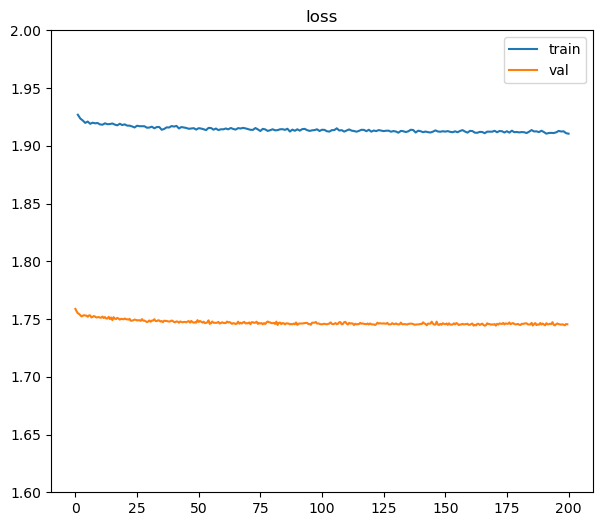

In [87]:
eval_per_epoch = len(val_losses_3) / len(train_losses_3)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7,6)

ax.plot([i + 1 for i in range(len(train_losses_3))], train_losses_3, label='train')
ax.plot([i / eval_per_epoch for i in range(len(val_losses_3))], val_losses_3, label='val')
ax.set_ylim(1.6, 2.)
ax.set_title('loss')

plt.legend()
plt.show()

In [88]:
model = trainer_2.get_model()
model.eval()
with torch.no_grad():
    val_rmsle = 0.
    val_loss = 0.
    y = test_dataset_3.y
    y_hat = model(test_dataset_3.X)
    #
    y_adjusted = torch.zeros(y.shape)
    y_hat_adjusted = torch.zeros(y_hat.shape)
    for i, (y_i, y_hat_i) in enumerate(zip(y, y_hat)):
        y_i_id = torch.argmax(y_i)
        y_hat_i_id = torch.argmax(F.softmax(y_hat_i, dim=0))
        #
        if y_i_id < 27:
            y_i_id = y_i_id + 1
        else:
            y_i_id = y_i_id + 2
        if y_hat_i_id < 27:
            y_hat_i_id = y_hat_i_id + 1
        else:
            y_hat_i_id = y_hat_i_id + 2
        # print(f"{y_hat_i_id} vs {y_i_id}")
        y_adjusted[i] = y_i_id
        y_hat_adjusted[i] = y_hat_i_id
    #
    rmsle = torch.log(y_hat_adjusted + 1) - torch.log(y_adjusted + 1)
    rmsle = torch.pow(rmsle, 2)
    rmsle = torch.mean(rmsle)
    rmsle = torch.sqrt(rmsle)
    print(rmsle)

tensor(0.1735)


## Submission

Test output to confirm that the rmsle calculation is correct.

In [ ]:
test_df = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s4e4/sample_submission.csv')
test_df.head(5)

In [ ]:
test_X_df = test_df.drop(columns=['Sex', 'id'])
def sex_to_int(x):
  if x == 'M':
    return 0
  elif x == 'F':
    return 1
  else:
    return 2
test_X_df['sex'] = test_df['Sex'].apply(sex_to_int)
test_X_df.head()

In [ ]:
test_X = torch.Tensor(test_X_df.values)
test_X_inputs, test_X_genders = torch.split(test_X, [7,1], dim=1)
model.eval()
with torch.no_grad():
  test_y_hat = model(test_X_inputs, test_X_genders.squeeze().long()).squeeze()
submission['Rings'] = test_y_hat

In [ ]:
submission.to_csv("submission.csv", index = False)